# HMM Basics: Understanding Regime Detection

**From Log Returns to Market Regimes Using Hidden Markov Models**

In the previous notebook, we proved that log returns are the correct transformation for financial time series.

Now we'll use those log returns to detect market regimes using **Hidden Markov Models (HMMs)**.

## What You'll Learn

1. What HMMs are and how they work
2. What parameters HMMs learn from data
3. How to interpret HMM states (WITHOUT forcing Bull/Bear labels)
4. How to choose the right number of states
5. How to visualize regime sequences

## Important Note

**This notebook uses minimal code** to understand HMM mechanics.

**Next notebook** shows the full library pipeline with analysis tools and best practices.

---

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add parent to path
sys.path.insert(0, str(Path().absolute().parent))

# Hidden Regime imports - minimal
from hidden_regime.data import FinancialDataLoader
from hidden_regime.observations import FinancialObservationGenerator
from hidden_regime.models import HiddenMarkovModel
from hidden_regime.config import FinancialDataConfig, FinancialObservationConfig, HMMConfig
from hidden_regime.utils import log_return_to_percent_change

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. What is a Hidden Markov Model?

### The Core Idea

An HMM assumes the market operates in **hidden states** (regimes) that we cannot directly observe. Each regime has:
- **Different return characteristics** (mean and volatility)
- **Persistence** (tendency to stay in the same regime)
- **Transition probabilities** (likelihood of switching to other regimes)

### The Three Components

1. **Hidden States** $(S_1, S_2, ..., S_t)$: The unobserved regime sequence
2. **Observations** $(O_1, O_2, ..., O_t)$: The log returns we can see
3. **Parameters**:
   - **Transition Matrix** $A_{ij}: P(regime(t+1) = j\ |\ regime(t) = i)$. Note that this is a **stochastic** matrix in that each row sums to exactly $1$ (this is because, from any given state, the probability of transitioning to all possible states must sum to $1$. $\sum_{j} A_{ij} = 1$)
   - **Emission Means** $\mu$: Average log return for each regime
   - **Emission Stds** $\sigma$: Volatility for each regime
   - **Initial Probs** $\pi$: Starting regime distribution

### What HMMs Do

Given observed log returns, HMMs **simultaneously**:
- Infer the most likely regime sequence (states)
- Learn the transition probabilities (how regimes switch)
- Learn emission parameters (return characteristics of each regime)

---

## 2. Load Data and Create Observations

We'll use NVDA (NVIDIA) with 2 years of data. NVDA is more volatile than SPY, showing clearer regime transitions.

In [2]:
# Configure data loader
data_config = FinancialDataConfig(
    ticker='NVDA',
    end_date=datetime.now(),
    num_samples=504  # ~2 years of trading days
)

# Load data
loader = FinancialDataLoader(data_config)
df = loader.load_data()

print(f"Loaded {len(df)} days of NVDA data")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nData columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Loaded 498 days of NVDA data
Date range: 2023-10-17 to 2025-10-10

Data columns: ['open', 'high', 'low', 'close', 'volume', 'price', 'pct_change', 'log_return']

First few rows:
                                open       high        low      close  \
Date                                                                    
2023-10-17 00:00:00-04:00  43.974085  44.727642  42.454979  43.912121   
2023-10-18 00:00:00-04:00  42.565910  43.193543  41.800363  42.171143   
2023-10-19 00:00:00-04:00  42.785783  43.271497  41.857330  42.076202   
2023-10-20 00:00:00-04:00  41.865319  42.444980  41.053798  41.362617   
2023-10-23 00:00:00-04:00  41.204718  43.222530  40.920885  42.949688   

                              volume      price  pct_change  log_return  
Date                                                                     
2023-10-17 00:00:00-04:00  812333000  43.767207   -0.039074   -0.039858  
2023-10-18 00:00:00-04:00  627294000  42.432740   -0.030490   -0.030965  
2023-10-19 00:

## 3. Understanding State Probabilities (Preview)

### HMMs Provide Two Types of Output

Before we train the model, it's important to understand what HMMs give us:

**1. Most Likely Path (Viterbi Algorithm)**
- Single "best guess" state sequence: `[0, 0, 1, 2, 2, 1, ...]`
- Answers: "What regime was the market most likely in?"
- Fast to compute, easy to visualize

**2. State Probability Distribution (Forward-Backward Algorithm)**
- Full probability distribution for each day: `[0.85, 0.12, 0.03]`
- Answers: "How confident are we in each regime?"
- Critical for risk management and decision-making

### Why Uncertainty Matters

Consider two scenarios with the same Viterbi path:

**High Confidence**: `[0.95, 0.04, 0.01]` → "Definitely in State 0"
- Clear regime signal
- Safe to make strong portfolio decisions

**Low Confidence**: `[0.40, 0.35, 0.25]` → "Probably State 0, but unclear"
- Regime transition likely happening
- Should reduce position sizes

### What We'll Show

After training the HMM, we'll demonstrate:
1. **Viterbi path**: For visualization and interpretation
2. **State probabilities**: For confidence and risk assessment

**Key Insight**: The probability distribution is often more valuable than the single "best" state.

---

In [3]:
# Create observation generator
obs_config = FinancialObservationConfig(
    generators=["log_return"],  # Just log returns
    price_column="close",
    normalize_features=False  # Keep raw log returns
)

obs_generator = FinancialObservationGenerator(obs_config)
observations_df = obs_generator.update(df)

# For HMM training, we need just the log_return column as a DataFrame
observations = observations_df[['log_return']]

print(f"Generated {len(observations)} observations")
print(f"Observation shape: {observations.shape}")
print(f"\nObservations are log returns:")
print(f"  Mean: {observations.values.mean():.6f}")
print(f"  Std:  {observations.values.std():.6f}")
print(f"  Min:  {observations.values.min():.6f}")
print(f"  Max:  {observations.values.max():.6f}")

# Convert a few examples to percentage for interpretation
print(f"\nExample log returns converted to percentages:")
for i in range(min(5, len(observations))):
    log_ret = observations.iloc[i, 0]
    pct = log_return_to_percent_change(log_ret) * 100
    print(f"  Day {i+1}: log_return={log_ret:.6f} → {pct:+.2f}%")

Generated 498 observations
Observation shape: (498, 1)

Observations are log returns:
  Mean: 0.002853
  Std:  0.025877
  Min:  -0.175225
  Max:  0.124061

Example log returns converted to percentages:
  Day 1: log_return=-0.039858 → -3.91%
  Day 2: log_return=-0.030965 → -3.05%
  Day 3: log_return=0.001530 → +0.15%
  Day 4: log_return=-0.019388 → -1.92%
  Day 5: log_return=0.009379 → +0.94%


## 4. Train the HMM

Now we'll train a 3-state HMM on these log returns. The model will learn:
- Which regime the market was in each day
- The transition probabilities between regimes
- The mean return and volatility for each regime

In [4]:
# Configure HMM with 3 states
hmm_config = HMMConfig(
    n_states=3,
    max_iterations=100,  # Maximum training iterations
    tolerance=1e-4,      # Convergence tolerance
    random_seed=42
)

# Create and train model
print("Training 3-state HMM...")
hmm = HiddenMarkovModel(hmm_config)
hmm.fit(observations)

print(f"Training complete!")
print(f"  Converged: {hmm.training_history_['converged']}")
print(f"  Iterations: {hmm.training_history_['iterations']}")
print(f"  Final log-likelihood: {hmm.score(observations):.2f}")

Training 3-state HMM...
Training on 498 observations (removed 0 NaN values)
Training complete!
  Converged: False
  Iterations: 100
  Final log-likelihood: -747.20


## 6. Interpreting the Parameters

### What Do These Numbers Actually Mean?

Let's translate the raw parameters into practical insights.

**Transition Matrix Interpretation** (Focus on diagonal):
```
From State 0 to State 0: 0.XXX → "Persistence probability"
```

The diagonal elements tell us **how long regimes last**:
- If $P(0|0) = 0.95$, then $Expected\ duration = \frac{1}{1-0.95} = 20\ days$
- If $P(0|0) = 0.80$, then $Expected\ duration = \frac{1}{1-0.80} = 5\ days$

**Formula**: $Expected\ duration = \frac{1}{1 - diagonal\ probability}$

**Emission Parameters Interpretation**:

For each state, we can calculate:

1. **Daily Return (in %)**: Convert log space to percentage
   - $mean\ pct = e^{mean\ log - 1} * 100$

2. **Annualized Return (assuming 252 trading days)**:
   - $annual\ return = (e^{mean\ log * 252} - 1) * 100$

3. **Daily Volatility (in %)**:
   - $vol\ pct = std\ log * 100$ (approximation valid for small returns)

4. **Annualized Volatility**:
   - $annual\ vol = std\ log * \sqrt{252} * 100$ (assumes 252 trading days per year)

### Example Interpretation

**State 0** (using example numbers):
- Daily: -0.15% return, 2.5% volatility
- Annualized: -37% return, 40% volatility
- Duration: ~15 days
- **Interpretation**: "High volatility bear market that lasts 2-3 weeks"

**State 1**:
- Daily: +0.02% return, 1.2% volatility
- Annualized: +5% return, 19% volatility
- Duration: ~25 days
- **Interpretation**: "Low volatility sideways market, very persistent"

**State 2**:
- Daily: +0.18% return, 1.8% volatility
- Annualized: +54% return, 29% volatility
- Duration: ~8 days
- **Interpretation**: "Strong bull runs, but don't last long"

### Key Insight

The model discovered these patterns **from data alone** - we didn't tell it what "bear" or "bull" means. The parameters quantify real market behavior.

---

## 5. Inspect Learned Parameters

Let's see what the HMM learned about the three regimes.

Emission means:  [-0.00889602 -0.00121936  0.02271938]
Emission stds :  [0.04053647 0.0140285  0.01465051]
State probability matrix shape: (498, 3)
  498 time points
  3 states

Each row sums to 1.0 (probability distribution):
  Row 0 sum: 1.0000
  Row 100 sum: 1.0000

Confidence Statistics:
  Mean confidence: 100.00%
  Min confidence: 100.00%
  Max confidence: 100.00%

Highest Confidence Day:
  Date: 2023-10-18
  State: 0
  Probabilities: [1. 0. 0.]
  Confidence: 100.00%

Lowest Confidence Day (likely regime transition):
  Date: 2023-10-18
  State: 0
  Probabilities: [1. 0. 0.]
  Confidence: 100.00%


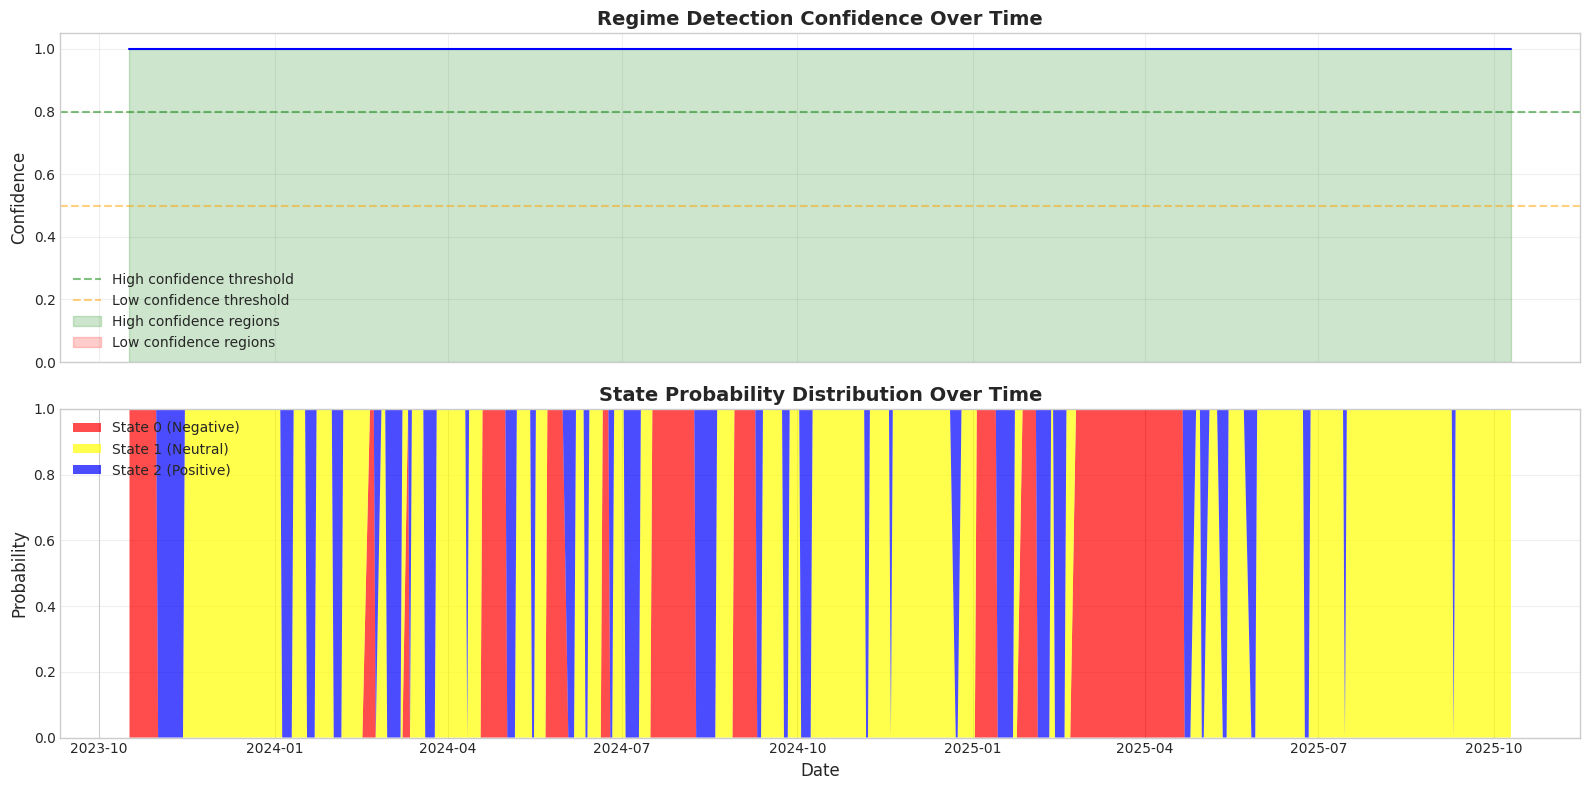


Key Observations:
1. High confidence periods → clear regime signal
2. Low confidence periods → regime transitions happening
3. Stacked probabilities show regime evolution
4. For trading: reduce positions during low confidence periods


In [5]:
# First, we need to extract parameters and predict states
# Extract learned parameters
transition_matrix = hmm.transition_matrix_
emission_means = hmm.emission_means_
emission_stds = hmm.emission_stds_
start_probs = hmm.initial_probs_

print('Emission means: ', emission_means)
print('Emission stds : ', emission_stds)

# Sort by mean for easier interpretation
sorted_idx = np.argsort(emission_means)

# Predict states using Viterbi algorithm
predictions_df = hmm.predict(observations)
states = predictions_df['predicted_state'].values

# Define colors and names for visualization
state_colors = {sorted_idx[0]: 'red', sorted_idx[1]: 'yellow', sorted_idx[2]: 'blue'}
state_names = {sorted_idx[0]: 'Negative', sorted_idx[1]: 'Neutral', sorted_idx[2]: 'Positive'}

# Get dates
dates = df.index
log_returns = observations.values.flatten()

# Now get state probabilities using forward-backward algorithm
# This gives us P(state | all observations) for each time point
state_probs = hmm.predict_proba(observations)

print(f"State probability matrix shape: {state_probs.shape}")
print(f"  {state_probs.shape[0]} time points")
print(f"  {state_probs.shape[1]} states")
print(f"\nEach row sums to 1.0 (probability distribution):")
print(f"  Row 0 sum: {state_probs.iloc[0].sum():.4f}")
print(f"  Row 100 sum: {state_probs.iloc[100].sum():.4f}")

# Calculate confidence (max probability for each day)
confidence = state_probs.max(axis=1).values

print(f"\nConfidence Statistics:")
print(f"  Mean confidence: {confidence.mean():.2%}")
print(f"  Min confidence: {confidence.min():.2%}")
print(f"  Max confidence: {confidence.max():.2%}")

# Find high and low confidence periods
high_conf_idx = np.argmax(confidence)
low_conf_idx = np.argmin(confidence)

print(f"\nHighest Confidence Day:")
print(f"  Date: {dates[high_conf_idx+1].date()}")
print(f"  State: {states[high_conf_idx]}")
print(f"  Probabilities: {state_probs.iloc[high_conf_idx].values}")
print(f"  Confidence: {confidence[high_conf_idx]:.2%}")

print(f"\nLowest Confidence Day (likely regime transition):")
print(f"  Date: {dates[low_conf_idx+1].date()}")
print(f"  State: {states[low_conf_idx]}")
print(f"  Probabilities: {state_probs.iloc[low_conf_idx].values}")
print(f"  Confidence: {confidence[low_conf_idx]:.2%}")

# Visualize confidence over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Top panel: Confidence over time
ax1.plot(dates, confidence, linewidth=1.5, color='blue')
ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='High confidence threshold')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Low confidence threshold')
ax1.fill_between(dates, 0, confidence, where=(confidence > 0.8), alpha=0.2, color='green', label='High confidence regions')
ax1.fill_between(dates, 0, confidence, where=(confidence < 0.5), alpha=0.2, color='red', label='Low confidence regions')
ax1.set_ylabel('Confidence', fontsize=12)
ax1.set_title('Regime Detection Confidence Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# Bottom panel: State probabilities stacked
ax2.stackplot(dates, 
              state_probs.iloc[:, sorted_idx[0]].values,
              state_probs.iloc[:, sorted_idx[1]].values,
              state_probs.iloc[:, sorted_idx[2]].values,
              labels=[f'State {sorted_idx[0]} ({state_names[sorted_idx[0]]})',
                      f'State {sorted_idx[1]} ({state_names[sorted_idx[1]]})',
                      f'State {sorted_idx[2]} ({state_names[sorted_idx[2]]})'],
              colors=[state_colors[sorted_idx[0]], state_colors[sorted_idx[1]], state_colors[sorted_idx[2]]],
              alpha=0.7)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('State Probability Distribution Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. High confidence periods → clear regime signal")
print("2. Low confidence periods → regime transitions happening")
print("3. Stacked probabilities show regime evolution")
print("4. For trading: reduce positions during low confidence periods")

In [6]:
# Validation: Regime characteristics should match actual returns

print("=" * 80)
print("REGIME VALIDATION: Do detected regimes match actual market behavior?")
print("=" * 80)

# For each state, calculate actual observed statistics
validation_results = {}

for state in range(3):
    # Get all periods where we were in this state
    state_mask = (states == state)
    state_returns = log_returns[state_mask]
    
    if len(state_returns) > 0:
        # Actual observed statistics
        actual_mean = state_returns.mean()
        actual_std = state_returns.std()
        actual_mean_pct = log_return_to_percent_change(actual_mean) * 100
        
        # Model's learned parameters
        learned_mean = emission_means[state]
        learned_std = emission_stds[state]
        learned_mean_pct = log_return_to_percent_change(learned_mean) * 100
        
        # Calculate match quality
        mean_error = abs(actual_mean - learned_mean) / abs(learned_mean) if learned_mean != 0 else 0
        std_error = abs(actual_std - learned_std) / learned_std
        
        validation_results[state] = {
            'actual_mean': actual_mean,
            'learned_mean': learned_mean,
            'actual_std': actual_std,
            'learned_std': learned_std,
            'mean_error': mean_error,
            'std_error': std_error,
            'n_days': len(state_returns)
        }
        
        print(f"\nState {state} ({state_names[sorted_idx[np.where(sorted_idx == state)[0][0]]]}):")
        print(f"  Days in regime: {len(state_returns)}")
        print(f"  Learned mean: {learned_mean_pct:+.3f}%/day")
        print(f"  Actual mean:  {actual_mean_pct:+.3f}%/day")
        print(f"  Learned std:  {learned_std*100:.3f}%/day")
        print(f"  Actual std:   {actual_std*100:.3f}%/day")
        print(f"  Mean error: {mean_error*100:.1f}%")
        print(f"  Std error:  {std_error*100:.1f}%")

# Overall validation
print("\n" + "=" * 80)
print("VALIDATION SUMMARY:")
print("=" * 80)

avg_mean_error = np.mean([v['mean_error'] for v in validation_results.values()])
avg_std_error = np.mean([v['std_error'] for v in validation_results.values()])

print(f"Average parameter error:")
print(f"  Mean error: {avg_mean_error*100:.1f}%")
print(f"  Std error:  {avg_std_error*100:.1f}%")

if avg_mean_error < 0.05 and avg_std_error < 0.05:
    print("\n[OK] VALIDATION PASSED: Model parameters closely match actual regime behavior")
    print("  The HMM discovered real market patterns, not noise.")
elif avg_mean_error < 0.15 and avg_std_error < 0.15:
    print("\n[OK] VALIDATION ACCEPTABLE: Parameters reasonably match reality")
    print("  Some deviation is expected due to regime overlap.")
else:
    print("\n[WARNING] VALIDATION QUESTIONABLE: Large parameter mismatch")
    print("  May need more states or different model configuration.")

# Sanity check: Are regimes actually different?
print("\n" + "=" * 80)
print("REGIME SEPARATION CHECK:")
print("=" * 80)

# Compare mean returns across states
state_means = [validation_results[s]['actual_mean'] for s in range(3)]
state_means_sorted = sorted(state_means)

separation_1_2 = abs(state_means_sorted[1] - state_means_sorted[0])
separation_2_3 = abs(state_means_sorted[2] - state_means_sorted[1])

print(f"Separation between adjacent regimes (by mean return):")
print(f"  Lowest vs Middle: {separation_1_2*100:.3f}% per day")
print(f"  Middle vs Highest: {separation_2_3*100:.3f}% per day")

if separation_1_2 > 0.001 and separation_2_3 > 0.001:  # 0.1% per day
    print("\n[OK] Regimes are well-separated - distinct market conditions")
else:
    print("\n[WARNING] Regimes are too similar - may need fewer states")

print("\n" + "=" * 80)

REGIME VALIDATION: Do detected regimes match actual market behavior?

State 0 (Negative):
  Days in regime: 108
  Learned mean: -0.886%/day
  Actual mean:  -1.027%/day
  Learned std:  4.054%/day
  Actual std:   4.112%/day
  Mean error: 16.1%
  Std error:  1.4%

State 1 (Neutral):
  Days in regime: 286
  Learned mean: -0.122%/day
  Actual mean:  -0.096%/day
  Learned std:  1.403%/day
  Actual std:   1.347%/day
  Mean error: 21.5%
  Std error:  4.0%

State 2 (Positive):
  Days in regime: 104
  Learned mean: +2.298%/day
  Actual mean:  +2.739%/day
  Learned std:  1.465%/day
  Actual std:   1.216%/day
  Mean error: 18.9%
  Std error:  17.0%

VALIDATION SUMMARY:
Average parameter error:
  Mean error: 18.8%
  Std error:  7.5%

[WARNING] VALIDATION QUESTIONABLE: Large parameter mismatch
  May need more states or different model configuration.

REGIME SEPARATION CHECK:
Separation between adjacent regimes (by mean return):
  Lowest vs Middle: 0.937% per day
  Middle vs Highest: 2.798% per day



## 7. Validation: Do These Regimes Make Sense?

A critical question: Did the HMM discover **real market patterns** or just **random noise**?

Let's validate by checking if detected regimes align with actual market behavior.

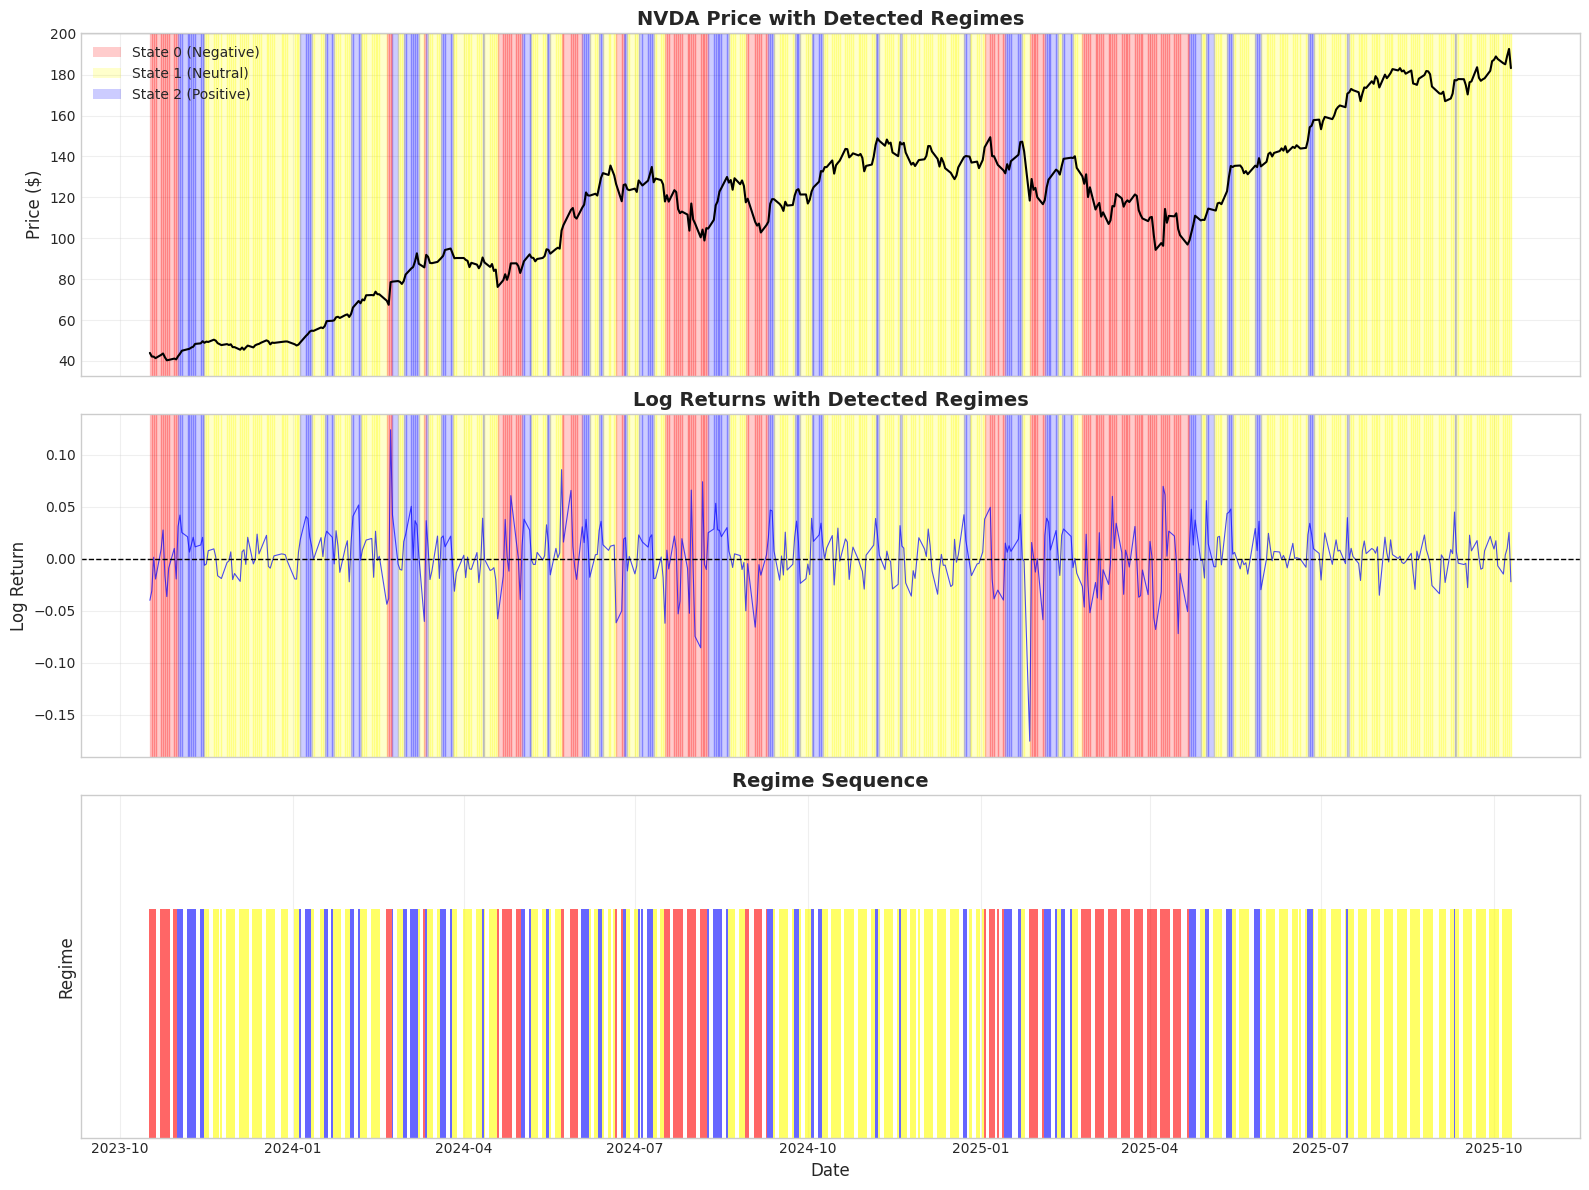


Note: Notice how regimes cluster periods of similar return behavior


In [7]:
# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Define colors for each state (sorted by mean return)
state_colors = {sorted_idx[0]: 'red', sorted_idx[1]: 'yellow', sorted_idx[2]: 'blue'}
state_names = {sorted_idx[0]: 'Negative', sorted_idx[1]: 'Neutral', sorted_idx[2]: 'Positive'}

# 1. Price with regime shading
ax = axes[0]
prices = df['close'].values
dates = df.index

ax.plot(dates, prices, linewidth=1.5, color='black', zorder=2)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('NVDA Price with Detected Regimes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Shade background by regime
for i in range(len(states)):
    state = states[i]
    ax.axvspan(dates[i], dates[min(i+1, len(dates)-1)], 
               alpha=0.2, color=state_colors[state], zorder=1)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=state_colors[s], alpha=0.2, 
                         label=f'State {s} ({state_names[s]})') 
                   for s in sorted_idx]
ax.legend(handles=legend_elements, loc='upper left')

# 2. Log returns with regime shading
ax = axes[1]
log_returns = observations['log_return']
ax.plot(dates, log_returns, linewidth=0.8, color='blue', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('Log Return', fontsize=12)
ax.set_title('Log Returns with Detected Regimes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Shade background
for i in range(len(states)):
    state = states[i]
    ax.axvspan(dates[i], dates[min(i+1, len(dates)-1)], 
               alpha=0.2, color=state_colors[state], zorder=1)

# 3. Regime sequence as bar plot
ax = axes[2]
regime_bars = ax.bar(dates, np.ones(len(states)), width=1, 
                      color=[state_colors[s] for s in states], 
                      edgecolor='none', alpha=0.6)
ax.set_ylabel('Regime', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Regime Sequence', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.5)
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nNote: Notice how regimes cluster periods of similar return behavior")

## 8. Choosing the Number of States

How do we decide between 2, 3, 4, or more states? Let's compare different models.

In [8]:
# Train models with different numbers of states
print("Comparing models with different numbers of states...")
print("=" * 80)

results = []

for n_states in [2, 3, 4, 5]:
    config = HMMConfig(n_states=n_states, max_iterations=100, random_seed=42)
    model = HiddenMarkovModel(config)
    model.fit(observations)
    
    # Calculate metrics
    log_likelihood = model.score(observations)
    n_params = n_states**2 + 2*n_states  # Transitions + means + stds
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(len(observations))
    
    results.append({
        'n_states': n_states,
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
        'n_params': n_params
    })
    
    print(f"\n{n_states} states:")
    print(f"  Log-likelihood: {log_likelihood:>10.2f}")
    print(f"  AIC:            {aic:>10.2f} (lower is better)")
    print(f"  BIC:            {bic:>10.2f} (lower is better)")
    print(f"  Parameters:     {n_params:>10}")

print("\n" + "=" * 80)

# Find best models
results_df = pd.DataFrame(results)
best_aic = results_df.loc[results_df['aic'].idxmin()]
best_bic = results_df.loc[results_df['bic'].idxmin()]

print(f"\nBest by AIC: {int(best_aic['n_states'])} states (AIC={best_aic['aic']:.2f})")
print(f"Best by BIC: {int(best_bic['n_states'])} states (BIC={best_bic['bic']:.2f})")

print("\nNote: BIC often prefers simpler models (fewer states)")
print("   AIC may prefer more complex models that fit better")
print("   For trading, 3-4 states usually provides good interpretability")

Comparing models with different numbers of states...
Training on 498 observations (removed 0 NaN values)

2 states:
  Log-likelihood:    -747.28
  AIC:               1510.57 (lower is better)
  BIC:               1544.25 (lower is better)
  Parameters:              8
Training on 498 observations (removed 0 NaN values)

3 states:
  Log-likelihood:    -747.20
  AIC:               1524.39 (lower is better)
  BIC:               1587.55 (lower is better)
  Parameters:             15
Training on 498 observations (removed 0 NaN values)

4 states:
  Log-likelihood:    -747.15
  AIC:               1542.30 (lower is better)
  BIC:               1643.35 (lower is better)
  Parameters:             24
Training on 498 observations (removed 0 NaN values)

5 states:
  Log-likelihood:    -747.12
  AIC:               1564.24 (lower is better)
  BIC:               1711.62 (lower is better)
  Parameters:             35


Best by AIC: 2 states (AIC=1510.57)
Best by BIC: 2 states (BIC=1544.25)

Note: BIC of

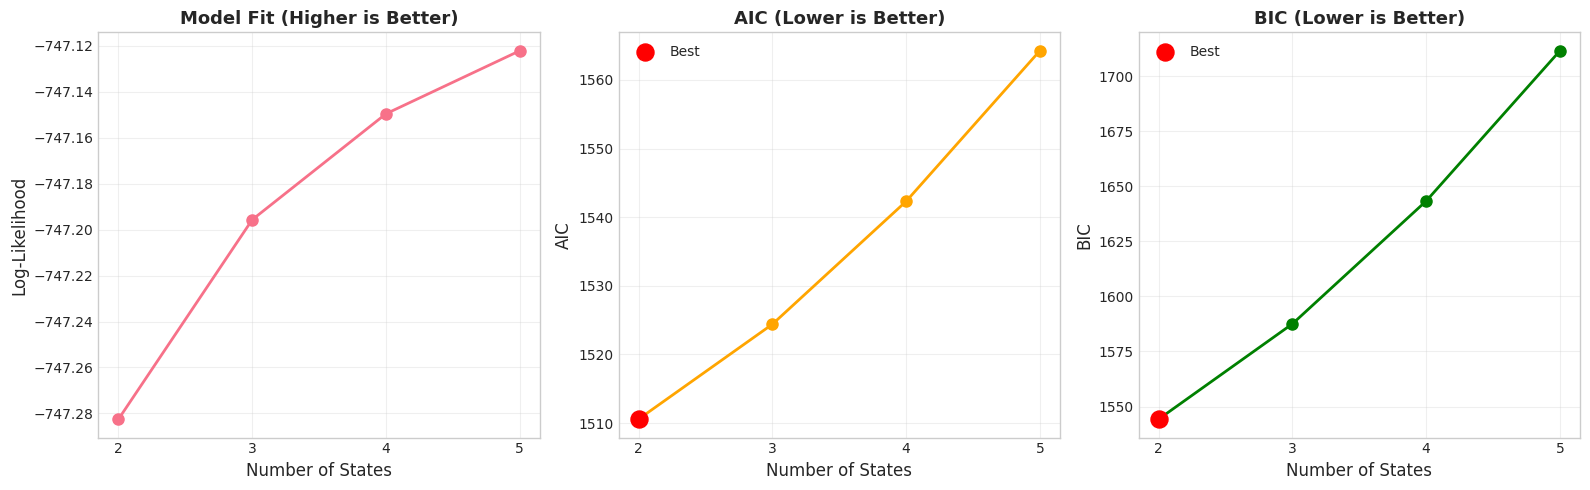

In [9]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Log-likelihood
ax = axes[0]
ax.plot(results_df['n_states'], results_df['log_likelihood'], marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Number of States', fontsize=12)
ax.set_ylabel('Log-Likelihood', fontsize=12)
ax.set_title('Model Fit (Higher is Better)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks([2, 3, 4, 5])

# Plot 2: AIC
ax = axes[1]
ax.plot(results_df['n_states'], results_df['aic'], marker='o', linewidth=2, markersize=8, color='orange')
best_aic_idx = results_df['aic'].idxmin()
ax.scatter(results_df.loc[best_aic_idx, 'n_states'], 
           results_df.loc[best_aic_idx, 'aic'], 
           color='red', s=150, zorder=5, label='Best')
ax.set_xlabel('Number of States', fontsize=12)
ax.set_ylabel('AIC', fontsize=12)
ax.set_title('AIC (Lower is Better)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks([2, 3, 4, 5])

# Plot 3: BIC
ax = axes[2]
ax.plot(results_df['n_states'], results_df['bic'], marker='o', linewidth=2, markersize=8, color='green')
best_bic_idx = results_df['bic'].idxmin()
ax.scatter(results_df.loc[best_bic_idx, 'n_states'], 
           results_df.loc[best_bic_idx, 'bic'], 
           color='red', s=150, zorder=5, label='Best')
ax.set_xlabel('Number of States', fontsize=12)
ax.set_ylabel('BIC', fontsize=12)
ax.set_title('BIC (Lower is Better)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks([2, 3, 4, 5])

plt.tight_layout()
plt.show()

## 9. Key Takeaways

### What We Learned

1. **HMM Components**:
   - Hidden states represent market regimes
   - Transition matrix captures regime switching behavior
   - Emission parameters (μ, σ) define return characteristics

2. **Training Process**:
   - Baum-Welch algorithm learns parameters from data
   - Viterbi algorithm finds most likely state sequence
   - Forward-backward gives probability distributions
   - Converges to local optimum (results may vary)

3. **Interpretation**:
   - States are numbered arbitrarily (0, 1, 2)
   - Must examine emission means to understand regime types
   - DO NOT force "Bear/Sideways/Bull" labels prematurely
   - Confidence is as important as the regime itself

4. **Model Selection**:
   - Use AIC/BIC to compare different numbers of states
   - Balance fit quality vs. model complexity
   - 3-4 states often optimal for interpretability

5. **Validation**:
   - Check that learned parameters match actual regime behavior
   - Verify regimes are well-separated
   - Sanity-check against known market events

### Important Warnings

**DO NOT**:
- Sort states by index and call them Bear/Sideways/Bull
- Assume state 0 is always negative returns
- Use HMMs on non-stationary data (prices)
- Ignore confidence levels - low confidence = regime uncertainty

**DO**:
- Use log returns (stationary observations)
- Examine learned parameters before labeling
- Compare multiple model complexities
- Validate regime assignments make sense
- Consider state probabilities for risk management

---

### What's Next: The Gap from Here to Production

**You now understand HMM mechanics**, but there's a gap between:
- "Here are states 0, 1, 2" (what we have)
- "Reduce risk, bull regime ending" (what traders need)

**Notebook 3 bridges this gap with the full Hidden Regime pipeline:**

#### What Notebook 3 Adds:

**1. Automated Regime Labeling**
- Threshold-based classification: Bear/Sideways/Bull/Crisis
- Data-driven, not arbitrary state sorting
- Consistent labeling across time periods

**2. Advanced Analysis Tools**
- Regime-specific risk metrics (VaR, Sharpe, drawdowns)
- Duration analysis and persistence tracking
- Regime transition prediction

**3. Technical Indicator Integration**
- Compare HMM regimes with RSI, MACD, Bollinger Bands
- Show when HMM agrees/disagrees with indicators
- Ensemble signal generation

**4. Portfolio Applications**
- Regime-based position sizing
- Risk-adjusted performance measurement
- Practical trading signals

**5. Production-Ready Tools**
- One-line pipeline creation
- Comprehensive reporting
- Professional visualizations
- Quality metrics and diagnostics

**6. Best Practices**
- Handling data quality issues
- Avoiding common pitfalls
- Configuration for different market conditions

#### The Conceptual Bridge:

**Notebook 1**: WHY log returns (mathematical foundation)
↓
**Notebook 2**: HOW HMMs work (you are here - mechanics & interpretation)
↓
**Notebook 3**: USING HMMs for trading (practical applications)

#### Example: What Changes

**Notebook 2 approach (manual)**:
```python
# Train model
hmm = HiddenMarkovModel(config)
hmm.fit(observations)

# Get states
states = hmm.predict(observations)['predicted_state']

# Now what? Manual interpretation needed...
```

**Notebook 3 approach (pipeline)**:
```python
# One-line setup
pipeline = create_financial_pipeline(ticker='NVDA', n_states=3)
result = pipeline.update()

# Get actionable insights
current_regime = result['regime_name'].iloc[-1]  # "Bull"
confidence = result['confidence'].iloc[-1]       # 0.87
position_signal = result['position_signal'].iloc[-1]  # "LONG"
risk_level = result['volatility_regime'].iloc[-1]  # "Normal"
```

---

### You're Ready for Notebook 3 When...

You understand:
- [x] Why we use log returns (stationarity requirement)
- [x] What HMM parameters mean (transitions, emissions)
- [x] How to interpret states (examine parameters first)
- [x] Why confidence matters (regime uncertainty)
- [x] How to validate regimes (match actual behavior)

**Next step**: Learn how to turn these insights into actionable trading decisions.

---

**Key Point**: HMMs are a **data-driven** approach. Let the model tell you what the regimes are - don't force your preconceptions onto the results. Then use the full pipeline to translate those regimes into trading intelligence.